# Testing code for project segments

#### CVAR test

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm, chi2

from swarm_prm.solvers.utils.gaussian_prm import GaussianNode
from swarm_prm.envs.roadmap import Roadmap, Obstacle 


def obstacle_gaussian_collision(obs: Obstacle, g_node: GaussianNode, alpha, thresh, ax) -> bool:
    """
        Using CVaR and threshold to test if node is too close to obstacle.
        Return True if CVaR is greater than the threshold.
        Reference: SwarmPRM
    """

    # return True if mean of Gaussian is indeed inside the obstacle
    if obs.is_point_colliding(g_node.get_mean()):
        return True

    # Plot normal vector
    mean = obs.get_dist(g_node.get_mean())
    nearest_point = obs.get_nearest_point(g_node.get_mean())
    v = nearest_point - g_node.get_mean()
    v_normal =  v / np.linalg.norm(v)

    start_pos = g_node.get_mean()
    end_pos = start_pos + v_normal * mean
    vec = np.vstack([start_pos, end_pos]).T
    ax.plot(vec[0], vec[1])

    variance = v_normal.T @ g_node.covariance @ v_normal
    std_variance = np.sqrt(variance)
    ita = norm(-mean, std_variance)
    cvar = mean + ita.pdf(ita.ppf(1-alpha))/alpha * std_variance 
    # print(cvar)
    return cvar > thresh

def visualize_g_node(g_node, ax, thresh, is_collision):
    # Visualize G nodes
    mean, cov = g_node.get_gaussian()
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors by descending eigenvalue
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # The angle of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # The width and height of the ellipse (2*sqrt(chi2_value*eigenvalue))
    chi2_value = chi2.ppf(thresh, 2)  # threshold confidence interval for 2 degrees of freedom (chi-squared value)
    width, height = 2 * np.sqrt(chi2_value * eigenvalues)
    if is_collision:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="red", fc='None', lw=2)
    else:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="blue", fc='None', lw=2)
    ax.add_patch(ellipse)


In [ ]:
roadmap = Roadmap(100, 100)
pos = np.array([50.0, 50.0])
# obs = Obstacle(None, "POLYGON", [(45, 45), (45, 55), (55, 55), (55, 45)]) # Polygon

obs = Obstacle(pos, "CIRCLE", 14) # Circle

thresh = -100.0
tolerance = 0.9
alpha = 0.1
num_g_node = 10 

roadmap.add_obstacle(obs)
fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# start_cov = np.eye(2) * 10
# goal_cov = np.eye(2) * 10
temp = np.random.rand(2, 2) * 10
start_cov =  temp @ temp.T
temp = np.random.rand(2, 2) * 10
goal_cov =  temp @ temp.T

for i in range(num_g_node):
    mean = i / (num_g_node) * start_mean + (num_g_node - i) / num_g_node * goal_mean
    cov = i / (num_g_node) * start_cov + (num_g_node - i) / num_g_node * goal_cov


    g_node = GaussianNode(mean, cov)
    is_collision = obstacle_gaussian_collision(obs,  g_node, alpha, thresh, ax)
    
    visualize_g_node(g_node, ax, tolerance, is_collision)

## Voronoi Diagram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, LineString, MultiPoint

def compute_voronoi(points, bounding_polygon):
    """
    Compute Voronoi diagram clipped by a bounding polygon.
    """
    vor = Voronoi(points)
    regions = []
    for region_index in vor.regions:
        if not region_index or -1 in region_index:
            continue
        polygon_points = [vor.vertices[i] for i in region_index]
        voronoi_polygon = Polygon(polygon_points)
        if bounding_polygon.contains(voronoi_polygon):
            regions.append(voronoi_polygon.intersection(bounding_polygon))
        else:
            regions.append(None)
    return vor, regions

def compute_centroids(regions):
    """
    Compute centroids of the Voronoi cells.
    """
    centroids = []
    for region in regions:
        if region and not region.is_empty:
            centroids.append(region.centroid.coords[0])
    return np.array(centroids)

def compute_voronoi_with_clipping(points, bounding_polygon):
    """
    Compute Voronoi diagram clipped by a bounding polygon.
    """
    vor = Voronoi(points)
    new_regions = []
    new_vertices = [tuple(v) for v in vor.vertices]  # Convert vertices to tuples

    # Map infinite regions to the boundary polygon
    for region_index in vor.regions:
        if not region_index or -1 in region_index:
            # Handle infinite regions
            region = [v for v in region_index if v != -1]
            if not region:
                continue
            
            # Start with finite vertices
            new_region = [tuple(vor.vertices[v]) for v in region]  # Convert to tuples
            
            # Find the ridges that go to infinity
            for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
                simplex = np.asarray(simplex)
                if np.any(simplex < 0):  # Infinite ridge
                    i = simplex[simplex >= 0][0]  # Finite endpoint of the ridge
                    
                    # Direction of the line from the finite point towards infinity
                    t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                    t = t / np.linalg.norm(t)
                    n = np.array([-t[1], t[0]])  # normal vector

                    # Compute a point far away in the direction of the normal
                    far_point = vor.vertices[i] + n * 1000

                    # Clip the line with the bounding polygon
                    line = LineString([vor.vertices[i], far_point])
                    clipped_line = line.intersection(bounding_polygon)
                    
                    if not clipped_line.is_empty:
                        # Handle different types of intersections (Point, MultiPoint)
                        if isinstance(clipped_line, MultiPoint):
                            for point in clipped_line:
                                point_tuple = tuple(point.coords[0])
                                if point_tuple not in new_vertices:
                                    new_region.append(point_tuple)
                                    new_vertices.append(point_tuple)
                        elif isinstance(clipped_line, Point):
                            point_tuple = tuple(clipped_line.coords[0])
                            if point_tuple not in new_vertices:
                                new_region.append(point_tuple)
                                new_vertices.append(point_tuple)
            
            # Convert back to indices
            new_region = [new_vertices.index(vertex) for vertex in new_region]
            new_regions.append(new_region)
        else:
            # Handle finite regions
            new_regions.append(region_index)
    
    return new_regions, np.array(new_vertices)

def plot_voronoi_with_clipping(voronoi, regions, vertices, obstacles, bounding_polygon):
    """
    Plot Voronoi diagram with the clipped regions for infinite cells.
    """
    plt.figure(figsize=(10, 10))

    # Plot each valid Voronoi region
    for region in regions:
        polygon_points = [vertices[i] for i in region]

        # Ensure valid polygon has at least 4 points and forms a closed loop
        if len(polygon_points) < 3:
            continue  # Skip if not enough points to form a polygon

        if len(polygon_points) >= 3 and polygon_points[0][0] != polygon_points[-1][0] and polygon_points[0][1] != polygon_points[-1][1]:
            polygon_points.append(polygon_points[0])  # Close the loop if needed
        
        if len(polygon_points) < 4:
            continue  # Ensure the polygon is valid

        voronoi_polygon = Polygon(polygon_points)
        
        # Clip the Voronoi cell with the bounding polygon
        voronoi_polygon = voronoi_polygon.intersection(bounding_polygon)
        
        # Exclude regions that overlap with obstacles
        if voronoi_polygon.is_empty or any(voronoi_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        x, y = voronoi_polygon.exterior.xy
        plt.fill(x, y, alpha=0.4, edgecolor='k')

    # Plot original Voronoi sites
    plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram with Clipped Infinite Regions")
    plt.show()

# Generate random initial points (Voronoi sites)


In [ ]:
num_samples = 500
num_iterations = 100

np.random.seed(42)
points = np.random.rand(num_samples, 2) * 100  # 20 random points in a 100x100 space

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Bounding polygon to limit Voronoi diagram to a finite area
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Compute Voronoi diagram with infinite regions clipped
for i in range(num_iterations):
    vor, regions = compute_voronoi(points, bounding_polygon)
    centroids = compute_centroids(regions) # Compute centroids of the Voronoi cells
    points = centroids # Update points to centroids

voronoi = Voronoi(points)
regions, vertices = compute_voronoi_with_clipping(points, bounding_polygon)

# Plot the resulting Voronoi diagram after clipping
plot_voronoi_with_clipping(voronoi, regions, vertices, obstacles, bounding_polygon)



### CVT test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                new_points.append(cell_polygon.centroid.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)

def plot_voronoi(voronoi, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))

    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

    # Plot Voronoi sites
    plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()

# Generate random initial points (Voronoi sites)
np.random.seed(42)
points = np.random.rand(50, 2) * 100  # 30 random points in a 100x100 space

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Perform Centroidal Voronoi Tessellation
iterations = 10
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles
    points = compute_centroids(voronoi, points, obstacles)

print(len(voronoi.regions))
# Plot the resulting Voronoi diagram after CVT
plot_voronoi(voronoi, obstacles)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, bounding_polygon, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect or go outside the bounding polygon.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                centroid = cell_polygon.centroid
                # Ensure the centroid is inside the bounding polygon
                if bounding_polygon.contains(centroid):
                    new_points.append(centroid.coords[0])
                else:
                    # If centroid is outside, keep the original point
                    # Alternatively, you could project it back onto the bounding polygon boundary
                    closest_point = bounding_polygon.exterior.interpolate(bounding_polygon.exterior.project(centroid))
                    new_points.append(closest_point.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)

def plot_voronoi(voronoi, bounding_polygon, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))

    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')
            

    # Plot Voronoi sites
    # plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot bounding polygon
    x, y = bounding_polygon.exterior.xy
    plt.plot(x, y, 'b-', lw=2)

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()

# Generate random initial points (Voronoi sites)
np.random.seed(42)
points = np.random.rand(500, 2) * 100  # 30 random points in a 100x100 space

# Define bounding polygon (a rectangular boundary)
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Perform Centroidal Voronoi Tessellation
iterations = 100
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles, constrained to the bounding polygon
    points = compute_centroids(voronoi, points, bounding_polygon, obstacles)

voronoi = compute_voronoi(points)
# Plot the resulting Voronoi diagram after CVT
plot_voronoi(voronoi, bounding_polygon, obstacles)


### IRIS python version

In [ ]:
import numpy as np
import cvxpy as cp
from scipy.spatial import ConvexHull

# Function to compute separating hyperplanes
def find_separating_hyperplanes(C, d, obstacles):
    A = []
    b = []
    for obstacle in obstacles:
        # Transform obstacle points into the space of the ellipsoid
        transformed_obstacle = np.dot(np.linalg.inv(C), (obstacle - d).T).T
        
        # Find the closest point to the origin in transformed space
        hull = ConvexHull(transformed_obstacle)
        closest_point = None
        min_dist = float('inf')
        for simplex in hull.simplices:
            point = transformed_obstacle[simplex].mean(axis=0)
            dist = np.linalg.norm(point)
            if dist < min_dist:
                min_dist = dist
                closest_point = point
        
        # Compute tangent plane in original space
        x_star = np.dot(C, closest_point) + d
        a_j = 2 * np.dot(np.linalg.inv(C).T, (x_star - d))
        b_j = np.dot(a_j, x_star)
        
        A.append(a_j)
        b.append(b_j)
    
    return np.array(A), np.array(b)

# Function to compute the maximum-volume ellipsoid
def find_maximum_ellipsoid(A, b):
    n = A.shape[1]
    C = cp.Variable((n, n), symmetric=True)
    d = cp.Variable(n)

    constraints = [C >> 0]  # C must be positive semidefinite
    for i in range(A.shape[0]):
        constraints.append(cp.norm(A[i] @ C) + A[i] @ d <= b[i])

    # Objective: maximize the log determinant of C (proportional to volume)
    obj = cp.Maximize(cp.log_det(C))
    prob = cp.Problem(obj, constraints)
    prob.solve()

    return C.value, d.value

# Main IRIS algorithm
def iris_algorithm(initial_point, obstacles, tolerance=1e-3, max_iterations=100):
    n = initial_point.shape[0]
    C = np.eye(n) * 1e-3  # Small initial ellipsoid
    d = initial_point

    for i in range(max_iterations):
        # Find separating hyperplanes
        A, b = find_separating_hyperplanes(C, d, obstacles)
        
        # Compute the maximum ellipsoid inscribed in the polytope
        C_new, d_new = find_maximum_ellipsoid(A, b)
        
        # Check for convergence
        if np.abs(np.linalg.det(C_new) - np.linalg.det(C)) / np.linalg.det(C) < tolerance:
            break
        
        C, d = C_new, d_new

    return C, d, A, b

# Example usage
if __name__ == "__main__":
    # Define some example obstacles as convex sets of points
    obstacles = [
        np.array([[2, 2], [3, 2], [3, 3], [2, 3]]),  # Square obstacle
        np.array([[5, 5], [6, 5], [6, 6], [5, 6]])   # Another square obstacle
    ]
    
    # Define the initial point (inside the free space)
    initial_point = np.array([1.0, 1.0])

    # Run the IRIS algorithm
    C, d, B, b = iris_algorithm(initial_point, obstacles)

    # Output results
    print("Maximal ellipsoid matrix (C):\n", C)
    print("Ellipsoid center (d):\n", d)
    print("Separating hyperplanes (A):\n", B)
    print("Hyperplane offsets (b):\n", b)


In [ ]:
import numpy as np
from shapely.geometry import Polygon, Point
from shapely.affinity import scale, rotate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import imageio

# Helper function to generate an ellipsoid as a Shapely shape
def generate_ellipsoid(center, radii, angle):
    circle = Point(center).buffer(1)  # Generate unit circle
    ellipsoid = scale(circle, radii[0], radii[1])  # Scale circle into an ellipsoid
    ellipsoid = rotate(ellipsoid, angle)
    return ellipsoid

# Function to compute separating hyperplanes using Shapely
def find_separating_hyperplanes(ellipsoid, obstacles):
    hyperplanes = []
    for obstacle in obstacles:
        # Compute the tangent line between the ellipsoid and the obstacle
        if ellipsoid.intersects(obstacle):
            # Find the intersection points and compute the separating plane
            tangent = ellipsoid.intersection(obstacle)
            # Add logic to compute separating hyperplanes (simple approximation here)
            hyperplanes.append(tangent)
    return hyperplanes

# Objective function: we try to maximize the area (proxy for volume in 2D) of the ellipsoid
def objective(params):
    center = params[:2]
    radii = params[2:]
    ellipsoid = generate_ellipsoid(center, radii)
    return -ellipsoid.area  # We minimize the negative of the area to maximize it

# Constraints: ensure the ellipsoid does not intersect with any obstacles
def constraint(params, obstacles):
    center = params[:2]
    radii = params[2:]
    ellipsoid = generate_ellipsoid(center, radii)
    for obstacle in obstacles:
        if ellipsoid.intersects(obstacle):
            return -1  # Violation: intersection detected
    return 1  # No intersection

# Function to visualize ellipsoid and obstacles
def plot_ellipsoid(ax, ellipsoid, color='blue'):
    x, y = ellipsoid.exterior.xy
    ax.fill(x, y, color=color, alpha=0.5, label='Ellipsoid')

def plot_obstacles(ax, obstacles):
    for obstacle in obstacles:
        x, y = obstacle.exterior.xy
        ax.fill(x, y, color='red', alpha=0.5)

# Main IRIS-like algorithm using Shapely and Scipy
def iris_algorithm_shapely(initial_point, obstacles, tolerance=1e-3, max_iterations=10):
    center = np.array(initial_point)
    radii = np.array([0.1, 0.1])  # Small initial radii for the ellipsoid

    frames = []
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, 7)
    ax.set_ylim(-1, 7)
    ax.set_aspect('equal')

    for i in range(max_iterations):
        ax.clear()
        ax.set_title(f"Iteration {i+1}")

        # Plot the obstacles
        plot_obstacles(ax, obstacles)

        # Generate current ellipsoid
        ellipsoid = generate_ellipsoid(center, radii)
        plot_ellipsoid(ax, ellipsoid, color='blue')

        # Find separating hyperplanes (visualizing hyperplanes not implemented for now)
        hyperplanes = find_separating_hyperplanes(ellipsoid, obstacles)

        # Save the current frame
        plt.draw()
        frame_path = f"./frame_{i}.png"
        plt.savefig(frame_path)
        frames.append(imageio.imread(frame_path))

        # Define the optimization problem
        params = np.hstack([center, radii])
        cons = {'type': 'ineq', 'fun': lambda x: constraint(x, obstacles)}
        result = minimize(objective, params, constraints=[cons])

        # Update the center and radii of the ellipsoid
        center, radii = result.x[:2], result.x[2:]

        # Check for convergence based on the change in ellipsoid area
        ellipsoid_new = generate_ellipsoid(center, radii)
        if abs(ellipsoid_new.area - ellipsoid.area) < tolerance:
            break

    # Generate GIF
    gif_path = "./iris_algorithm_shapely.gif"
    imageio.mimsave(gif_path, frames, fps=1)
    return gif_path

# Example usage
if __name__ == "__main__":
    # Define some example obstacles as convex sets of points (using Shapely Polygons)
    obstacles = [
        Polygon([(2, 2), (3, 2), (3, 3), (2, 3)]),  # Square obstacle
        Polygon([(5, 5), (6, 5), (6, 6), (5, 6)])   # Another square obstacle
    ]
    
    # Define the initial point (inside the free space)
    initial_point = [1.0, 1.0]

    # Run the IRIS algorithm using Shapely and Scipy
    gif_path = iris_algorithm_shapely(initial_point, obstacles)


### APF test

In [ ]:
from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import *
from swarm_prm.envs.roadmap import Roadmap, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Roadmap(100, 100)
pos = np.array([50, 50])
obs = Obstacle(pos, "CIRCLE", 10)
thresh = -10
tolerance = 0.95
alpha = 0.95
num_samples = 500

roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
num_agent = 10
agent_radius = 1
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10]])
goals = np.array([[90, 90]])

starts_weight = np.array([1])
goals_weight = np.array([1])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight, num_agent)
# instance.visualize()

gaussian_prm = GaussianPRM(instance, num_samples)
gaussian_prm.sample_free_space(sampling_strategy="UNIFORM_HALTON")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
# gaussian_prm.visualize_roadmap("test_map")
# gaussian_prm.visualize_g_nodes("test_g_nodes")


from swarm_prm.solvers.swarm_prm.macro.teg_nx import TEGGraph_NX
teg_graph= TEGGraph_NX(gaussian_prm, agent_radius, target_flow=num_agent)
max_flow, flow_dict, timestep, teg, restricted_edges  = teg_graph.find_earliest_timestep()
print("max flow", max_flow)
print("timestep", timestep)
print("flow_dict", flow_dict)
assert max_flow is not None, "Unable to find solution within the given timesteps"

simple_paths, gaussian_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)

In [ ]:
from swarm_prm.solvers.swarm_prm.micro.apf import APFSingleStepSolver
apf_solver = APFSingleStepSolver(roadmap, simple_paths, agent_radius, timestep, step_size=0.8, reach_thresh=1, max_timestep_iter=1000)
simple_paths, gaussian_paths = apf_solver.get_solution()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the artificial potential field
def attractive_potential(pos, goal, zeta=1.0):
    """Attractive potential (pulls agent toward goal)"""
    return 0.5 * zeta * np.linalg.norm(pos - goal) ** 2

def attractive_force(pos, goal, zeta=1.0):
    """Attractive force derived from the attractive potential"""
    return -zeta * (pos - goal)

def repulsive_potential(pos, obstacle, eta=100.0, Q=1.0):
    """Repulsive potential (pushes agent away from obstacles)"""
    dist = np.linalg.norm(pos - obstacle)
    if dist <= Q:
        return 0.5 * eta * ((1.0 / dist - 1.0 / Q) ** 2)
    else:
        return 0

def repulsive_force(pos, obstacle, eta=100.0, Q=1.0):
    """Repulsive force derived from the repulsive potential"""
    dist = np.linalg.norm(pos - obstacle)
    if dist <= Q:
        return eta * (1.0 / dist - 1.0 / Q) * (1.0 / dist ** 3) * (pos - obstacle)
    else:
        return np.array([0.0, 0.0])

def total_force(pos, goal, obstacles):
    """Compute the total force acting on the agent at a given position"""
    total_f = attractive_force(pos, goal)
    for obs in obstacles:
        total_f += repulsive_force(pos, obs)
    return total_f

# Environment setup
grid_size = (20, 20)
start = np.array([2, 2])
goal = np.array([17, 17])
obstacles = np.array([ [10, 10], [12, 14], [5, 17], [7, 8]])  # Example obstacle locations

# Simulation parameters
max_iterations = 1000
epsilon = 0.1  # Step size
threshold = 0.5  # Distance to goal to stop

# Initialize position
pos = start.copy()
trajectory = [pos.copy()]  # Store the trajectory for visualization

# Planning loop using artificial potential field
for i in range(max_iterations):
    force = total_force(pos, goal, obstacles)
    pos = pos + epsilon * force / np.linalg.norm(force)
    trajectory.append(pos.copy())
    
    # Stop if the agent reaches the goal
    if np.linalg.norm(pos - goal) < threshold:
        print(f"Reached goal in {i} iterations")
        break

# Visualization
trajectory = np.array(trajectory)

plt.figure(figsize=(8, 8))
plt.grid(True)
plt.xlim(0, grid_size[0])
plt.ylim(0, grid_size[1])
plt.scatter(goal[0], goal[1], color='green', label="Goal", s=100)
plt.scatter(obstacles[:, 0], obstacles[:, 1], color='red', label="Obstacles", s=100)
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label="Agent Path")
plt.scatter(start[0], start[1], color='orange', label="Start", s=100)
plt.legend()
plt.title('Artificial Potential Field Navigation')
plt.show()


## Obstacle segmentation test

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import triangle as tr

from swarm_prm.envs.roadmap import Obstacle

# Circle obstacle
obs = Obstacle([0, 0], "POLYGON", [[0, 0], [0, 10], [10, 10], [10, 0]])

# obs = Obstacle([7, 7], "CIRCLE", 5)
# hole1 = Obstacle([0, 0], "POLYGON", [[3, 3], [3, 6], [6, 6], [6, 3], [3, 3]])
hole2 = Obstacle([5, 5], "CIRCLE", 3)

# obs = Obstacle([0, 0], "CIRCLE", 30)
pts1, seg1, _ = obs.get_edge_segments(1)
pts2, seg2, hole_pos = hole2.get_edge_segments(0.5)

pts = np.vstack([pts1, pts2])
seg = np.vstack([seg1, seg2+seg1.shape[0]])

B = dict(vertices=pts, segments=seg, holes=[hole_pos])
B = tr.triangulate(B,"qpa2")

pts, edges, ray_origin, ray_direct = tr.voronoi(B['vertices'].tolist())
C = dict(vertices=pts, edges=edges,
         ray_origins=ray_origin, ray_directions=ray_direct)

# 
tr.compare(plt, B, C)


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

nodes = np.array([[0, 0], [0, 5], [5, 5], [5, 0], [0, 0]])
x = nodes[:, 0]
y = nodes[:, 1]

fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-")
plt.show()

### Voronoi test

In [ ]:
import matplotlib.pyplot as plt

import triangle as tr

spiral = tr.get_data("spiral")
t = tr.triangulate(spiral)

tr.plot(plt.axes(), **t)

plt.show()

## Repelling force node update

In [ ]:
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

# Function to create a hexagon centered at (x, y) with a given size (radius)
def create_hexagon(center_x, center_y, size):
    angle_offset = np.pi / 6  # 30 degrees offset to align flat-top hexagons
    return Polygon([(center_x + size * np.cos(2 * np.pi * i / 6 + angle_offset),
                     center_y + size * np.sin(2 * np.pi * i / 6 + angle_offset)) for i in range(6)])

# Step 1: Define the map boundary and obstacles
map_boundary = Polygon([(-10, -10), (-10, 10), (10, 10), (10, -10)])  # Square map boundary
obstacle_1 = Polygon([(-3, -3), (-3, 1), (0, 1), (0, -3)])  # Rectangular obstacle
obstacle_2 = Polygon([(2, 3), (5, 6), (7, 2)])  # Triangular obstacle

# List of obstacles
obstacles = [obstacle_1, obstacle_2]

# Step 2: Generate a hexagonal grid of points covering the space
hex_size = 1.0  # Hexagon radius
hex_width = hex_size * 2
hex_height = np.sqrt(3) * hex_size

# Create hexagonal grid points
grid_points = []
for i in range(-15, 15):  # Adjust range based on map size and hex size
    for j in range(-15, 15):
        x_offset = j * hex_height + (i % 2) * (hex_height / 2)  # Offset alternate rows
        y_offset = i * hex_width * 3 / 4
        hex_center = Point(x_offset, y_offset)
        if map_boundary.contains(hex_center):
            grid_points.append((x_offset, y_offset))

# Step 3: Create hexagons and check for intersection with obstacles
free_hexagons = []
for x, y in grid_points:
    hexagon = create_hexagon(x, y, hex_size)
    if not any(hexagon.intersects(obstacle) for obstacle in obstacles):
        free_hexagons.append(hexagon)

# Step 4: Visualization
fig, ax = plt.subplots()

# Plot the map boundary
x, y = map_boundary.exterior.xy
ax.plot(x, y, 'black', label='Map boundary')

# Plot obstacles
for obstacle in obstacles:
    x, y = obstacle.exterior.xy
    ax.fill(x, y, color='red', alpha=0.5, label='Obstacle')

# Plot free hexagons
for hexagon in free_hexagons:
    x, y = hexagon.exterior.xy
    ax.plot(x, y, 'green')

ax.set_aspect('equal')
plt.show()


## TEG macro solution test

In [ ]:
from swarm_prm.solvers.utils.gaussian_prm import *
from swarm_prm.envs.roadmap import Roadmap, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Roadmap(100, 100)
safety_radius = 2
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(40, 0), (40, 40), (80, 40), (80, 0)]),
    Obstacle(None, "POLYGON", [(40, 100), (40, 50), (80, 50), (80, 100)])
]
num_samples = 100 
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
num_agent = 10
agent_radius = 2
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
hex_radius = 3
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.5, .5])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight, num_agent)

gaussian_prm = GaussianPRM(instance, num_samples, safety_radius=safety_radius,
                           hex_radius=hex_radius)
gaussian_prm.sample_free_space(sampling_strategy="HEXAGON")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
# gaussian_prm.visualize_roadmap("test_map")
# gaussian_prm.visualize_g_nodes("test_g_nodes")


from swarm_prm.solvers.macro.teg_nx import TEGGraph_NX
teg_graph= TEGGraph_NX(gaussian_prm, agent_radius, target_flow=num_agent, max_timestep=500)
max_flow, flow_dict, timestep, teg, restricted_edges  = teg_graph.find_earliest_timestep()
print("max flow", max_flow)
print("timestep", timestep)

assert max_flow is not None, "Unable to find solution within the given timesteps"

macro_sol = gaussian_prm.get_macro_solution(flow_dict)
print(macro_sol)
# simple_paths, gaussian_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)

## Repelling force kernel

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
rep_coeff = 1
obs_thresh = 100
f = lambda x: 1/2 * rep_coeff * (1/abs(x) - 1/obs_thresh) ** 2

x = np.linspace(-5, 5, 500)

y = f(x)


plt.ylim(top=100)
plt.plot(x, y)
plt.show()


## Spatial Hash Test

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from swarm_prm.solvers.utils.spatial_hash import SpatialHash

num_points = 500
num_samples = 10

pts = []

coords = np.random.uniform(0, 100, (num_points, 2))

samples = np.mgrid[5:105:30, 5:105:30].reshape(2, -1).T

sh = SpatialHash(10)

for idx, pts in enumerate(coords):
    sh.insert(idx, pts)

fig, ax = plt.subplots(figsize=(8, 8))

cmap = plt.get_cmap("tab10")

for i, s in enumerate(samples):
    neigh = sh.query_radius(s, 10) 
    ax.plot(s[0], s[1], "+", color=cmap(i%7))
    for n in neigh:
        ax.plot(coords[n][0], coords[n][1], "o", color=cmap(i%7))


plt.grid(True)
plt.show()


## APF Boundary Test

In [ ]:
roadmap = Roadmap(100, 100)
pos = np.array([50, 50])
obs = Obstacle(pos, "CIRCLE", 10)
thresh = -10
tolerance = 0.95
alpha = 0.95
num_g_node = 10 

roadmap.add_obstacle(obs)
fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# start_cov = np.eye(2) * 10
# goal_cov = np.eye(2) * 10
temp = np.random.rand(2, 2) * 10
start_cov =  temp @ temp.T
temp = np.random.rand(2, 2) * 10
goal_cov =  temp @ temp.T

for i in range(num_g_node):
    mean = i / (num_g_node) * start_mean + (num_g_node - i) / num_g_node * goal_mean
    cov = i / (num_g_node) * start_cov + (num_g_node - i) / num_g_node * goal_cov

    g_node = GaussianNode(mean, cov)
    is_collision = obstacle_gaussian_collision(obs,  g_node, alpha, thresh, ax)
    visualize_g_node(g_node, ax, tolerance, is_collision)

In [ ]:
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint, box
from shapely.ops import polygonize, unary_union

def clip_voronoi_cells(vor, bounds):
    """
    Clip Voronoi cells to a bounding box or polygon.
    
    :param vor: Voronoi object from scipy.spatial.Voronoi.
    :param bounds: Bounding box as a shapely Polygon (e.g., box(xmin, ymin, xmax, ymax)).
    :return: List of clipped Voronoi cells as shapely Polygons.
    """
    clipped_cells = []
    for region_index in vor.point_region:
        region = vor.regions[region_index]
        if -1 not in region:  # Skip infinite regions
            polygon = Polygon(vor.vertices[region])
            clipped_polygon = polygon.intersection(bounds)
            if not clipped_polygon.is_empty:
                clipped_cells.append(clipped_polygon)
    return clipped_cells

def plot_clipped_voronoi(points, bounds):
    """
    Compute and plot the clipped Voronoi tessellation.
    
    :param points: Array of points (generators) for the Voronoi diagram.
    :param bounds: Bounding box as a shapely Polygon.
    """
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Clip Voronoi cells to the bounding box
    clipped_cells = clip_voronoi_cells(vor, bounds)
    
    # Plot the clipped Voronoi cells
    fig, ax = plt.subplots()
    for cell in clipped_cells:
        x, y = cell.exterior.xy
        ax.fill(x, y, alpha=0.4, edgecolor='k')
    
    # Plot the original points
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=5)
    
    # Set plot limits
    ax.set_xlim(bounds.bounds[0], bounds.bounds[2])
    ax.set_ylim(bounds.bounds[1], bounds.bounds[3])
    ax.set_aspect('equal')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate random points
    np.random.seed(42)
    points = np.random.rand(20, 2)  # 20 points in 2D
    
    # Define bounding box (xmin, ymin, xmax, ymax)
    bounds = box(0, 0, 1, 1)  # Unit square
    
    # Plot the clipped Voronoi tessellation
    plot_clipped_voronoi(points, bounds)

## Inscribed Ellipsoid Test

Center: [1.30659375e-15 9.19017063e-15]
Shape matrix A: [[2.09999998 0.3       ]
 [0.69999999 5.09999993]]


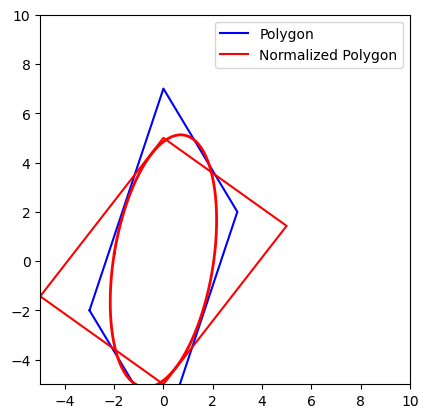

In [30]:
import numpy as np
import cvxpy as cp
from shapely.affinity import affine_transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import matplotlib.pyplot as plt

def get_polygon_inequalities(polygon: Polygon):
    """
    Computes the inequality constraints (Ax ≤ b) for a convex polygon.
    Returns:
        A: (m, d) array of normal vectors for each edge.
        b: (m, ) array of constraint bounds.
    """

    # Beware the vertices are in counter-clockwise order
    vertices = np.array(polygon.exterior.coords[:-1])  # Remove duplicate last point
    next_vertices = np.array(polygon.exterior.coords[1:])  # Next vertices for each edge

    mid_points = (vertices + next_vertices) / 2  # Midpoints of each edge

    edges = np.diff(vertices, axis=0, append=vertices[:1])  # Ensure all edges
    
    # Compute inward normal 
    normals = np.column_stack([-edges[:, 1], edges[:, 0]])  
    normals =  -normals / np.linalg.norm(normals, axis=1, keepdims=True)  # Normalize

    # Compute b = a_i^T v_i
    b = np.einsum('ij,ij->i', normals, mid_points)  
    return normals, b

def get_normalized_polygon(polygon: Polygon, scale=10):
    """
    Normalize a polygon to the unit circle.
    """
    polygon = orient(polygon, sign=1.0)  # Ensure counter-clockwise orientation
    centroid = np.array(polygon.centroid.xy)
    bounds = np.array(polygon.bounds)
    x_scale = bounds[2] - bounds[0] 
    y_scale = bounds[3] - bounds[1] 
    transform_matrix = np.array((scale / x_scale, scale / y_scale))
    offset = np.array([-centroid[0]* scale/x_scale , -centroid[1] * scale/y_scale])
    return affine_transform(polygon, [scale /x_scale, 0, 0, scale/y_scale, offset[0], offset[1]]), transform_matrix, offset, scale

def johns_ellipsoid_edge_constraints(polygon: Polygon):
    """
    Computes John's Ellipsoid (largest inscribed ellipsoid) for a convex polygon using CVXPY
    with polygon edge constraints instead of vertex constraints.
    """
    
    normalized_polygon, transform_matrix, offset, scale = get_normalized_polygon(polygon)
    A, b = get_polygon_inequalities(normalized_polygon)  # Compute polygon inequalities
    dim = A.shape[1]  # Dimension (should be 2 for 2D)

    # Define optimization variables
    B = cp.Variable((dim, dim), symmetric=True)  
    
    d = cp.Variable((dim,))  # Center of the ellipsoid

    # Ensure P is positive definite
    constraints = [ B >> 1e-3 * np.eye(dim)]

    # Edge constraints: max_{x ∈ E} a_i^T x ≤ b_i
    for i in range(A.shape[0]):
        constraints.append(cp.norm(B @ A[i].T, 2) <= b[i] - A[i].T @ d) 

    # log det (B^-1) = -log det (B)
    obj = cp.Maximize(cp.log_det(B))

    # Solve the convex optimization problem
    prob = cp.Problem(obj, constraints)
    prob.solve()

    if prob.status in ["optimal", "optimal_inaccurate"]:
        # Transform the ellipsoid back to the original spac
        t = np.diag(1/transform_matrix)
        return t@B.value, -t@(offset.squeeze() - d.value)

    else:
        print(prob.status)
        return None, None
        raise ValueError("Optimization failed.")

# Example Usage
# polygon = Polygon([(0, 0), (5, 0), (5, 5), (0, 5)])  # A simple rectangle
# polygon = Polygon([(0, 0), (0, 5), (5, 5), (5, 0)])  # A simple rectangle
# polygon = Polygon([(0, 0), (5, -1), (5, 3) ])  # A simple triangle
# polygon = Polygon([(0, 0), (0, 5), (3, 5) ])  # A simple triangle 
polygon = Polygon([(-3, -2), (0, -7), (3, 2), (0, 7) ])
# polygon = Polygon([(-3, -2), (3, -2), (3, 2), (-3, 2)])
# polygon = Polygon([(-3, 2), (-3, -2), (0, -3), (3, -2), (3, 2), (0, 3)])
A_matrix, center= johns_ellipsoid_edge_constraints(polygon)

print("Center:", center)
print("Shape matrix A:", A_matrix)

def plot_ellipsoid(ax, A, c):
    """
    Plot the ellipsoid defined by the shape matrix A and center c.
    """
    A = (A + A.T) / 2
    t = np.linspace(0, 2*np.pi, 100)
    circle = np.array([np.cos(t), np.sin(t)])
    eigvals, eigvecs = np.linalg.eigh(A)
    ellipse = eigvecs @ np.diag(eigvals) @ circle + c[:, None]
    ax.plot(ellipse[0], ellipse[1], 'r-', lw=2)

# Plot result
fig, ax = plt.subplots()
x, y = polygon.exterior.xy
ax.plot(x, y, 'b-', label='Polygon')

normalized_polygon, t_matrix, offset, scale = get_normalized_polygon(polygon)

x, y = normalized_polygon.exterior.xy   
ax.plot(x, y, 'r-', label="Normalized Polygon")

# Plot largest inscribed ellipsoid
if A_matrix is not None:
    plot_ellipsoid(ax, A_matrix, center)

ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)

ax.set_aspect('equal')
ax.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.affinity import affine_transform
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.geometry.polygon import orient

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, bounding_polygon, obstacles, target_num_cells):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Adjust number of points to match the target number of Voronoi cells.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                centroid = cell_polygon.centroid
                if bounding_polygon.contains(centroid):
                    new_points.append(centroid.coords[0])
                else:
                    new_point = tuple(np.random.rand(2) * 100)
                    new_points.append(new_point)
            else:
                new_points.append(point)
    
    # Adjust the number of points to match the target number of Voronoi cells
    while len(new_points) < target_num_cells:
        new_points.append(tuple(np.random.rand(2) * 100))  # Add random points
    while len(new_points) > target_num_cells:
        new_points.pop()  # Remove excess points
    
    return np.array(new_points)

def plot_voronoi(voronoi, bounding_polygon, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))

    ax = plt.gca()
    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

            # transform the polygon to range 0 to 1
            A_matrix, c = johns_ellipsoid_edge_constraints(cell_polygon)
            plot_ellipsoid(ax, A_matrix, c)

            

    # Plot Voronoi sites
    # plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot bounding polygon
    x, y = bounding_polygon.exterior.xy
    plt.plot(x, y, 'b-', lw=2)

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()

# Generate random initial points (Voronoi sites)
np.random.seed(42)
num_points = 400

# Define bounding polygon (a rectangular boundary)
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
    Point((20, 80)).buffer(5)
]

points = np.random.rand(100, 2) * 100
# Perform Centroidal Voronoi Tessellation
iterations = 100
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles, constrained to the bounding polygon
    points = compute_centroids(voronoi, points, bounding_polygon, obstacles, )

voronoi = compute_voronoi(points)
# Plot the resulting Voronoi diagram after CVT

plot_voronoi(voronoi, bounding_polygon, obstacles)


In [ ]:
import numpy as np
import cvxpy as cp
from shapely.affinity import affine_transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import matplotlib.pyplot as plt

def get_polygon_inequalities(polygon: Polygon):
    """
    Computes the inequality constraints (Ax ≤ b) for a convex polygon.
    Returns:
        A: (m, d) array of normal vectors for each edge.
        b: (m, ) array of constraint bounds.
    """

    # Beware the vertices are in counter-clockwise order
    vertices = np.array(polygon.exterior.coords[:-1])  # Remove duplicate last point
    next_vertices = np.array(polygon.exterior.coords[1:])  # Next vertices for each edge

    mid_points = (vertices + next_vertices) / 2  # Midpoints of each edge

    edges = np.diff(vertices, axis=0, append=vertices[:1])  # Ensure all edges
    
    # Compute inward normal 
    normals = np.column_stack([-edges[:, 1], edges[:, 0]])  
    normals =  -normals / np.linalg.norm(normals, axis=1, keepdims=True)  # Normalize

    # Compute b = a_i^T v_i
    b = np.einsum('ij,ij->i', normals, mid_points)  
    return normals, b

def get_normalized_polygon(polygon: Polygon, scale=10):
    """
    Normalize a polygon to the unit circle.
    """
    polygon = orient(polygon, sign=1.0)  # Ensure counter-clockwise orientation
    centroid = np.array(polygon.centroid.xy)
    bounds = np.array(polygon.bounds)
    x_scale = bounds[2] - bounds[0] 
    y_scale = bounds[3] - bounds[1] 
    transform_matrix = np.array((scale / x_scale, scale / y_scale))
    offset = np.array([-centroid[0]* scale/x_scale , -centroid[1] * scale/y_scale])
    return affine_transform(polygon, [scale /x_scale, 0, 0, scale/y_scale, offset[0], offset[1]]), transform_matrix, offset, scale

def johns_ellipsoid_edge_constraints(polygon: Polygon):
    """
    Computes John's Ellipsoid (largest inscribed ellipsoid) for a convex polygon using CVXPY
    with polygon edge constraints instead of vertex constraints.
    """
    
    normalized_polygon, transform_matrix, offset, scale = get_normalized_polygon(polygon)
    A, b = get_polygon_inequalities(normalized_polygon)  # Compute polygon inequalities
    dim = A.shape[1]  # Dimension (should be 2 for 2D)

    # Define optimization variables
    B = cp.Variable((dim, dim), symmetric=True)  
    
    d = cp.Variable((dim,))  # Center of the ellipsoid

    # Ensure P is positive definite
    constraints = [ B >> 1e-3 * np.eye(dim)]

    # Edge constraints: max_{x ∈ E} a_i^T x ≤ b_i
    for i in range(A.shape[0]):
        constraints.append(cp.norm(B @ A[i].T, 2) <= b[i] - A[i].T @ d) 

    # log det (B^-1) = -log det (B)
    obj = cp.Maximize(cp.log_det(B))

    # Solve the convex optimization problem
    prob = cp.Problem(obj, constraints)
    prob.solve()

    if prob.status in ["optimal", "optimal_inaccurate"]:
        # Transform the ellipsoid back to the original space
        t = np.diag(1/transform_matrix)
        return t@B.value, -t@(offset.squeeze() - d.value)

    else:
        print(prob.status)
        return None, None
        raise ValueError("Optimization failed.")

def plot_ellipsoid(ax, A, c):
    """
    Plot the ellipsoid defined by the shape matrix A and center c.
    """
    A = (A + A.T) / 2
    t = np.linspace(0, 2*np.pi, 100)
    circle = np.array([np.cos(t), np.sin(t)])
    U, S, _ = np.linalg.svd(A)
    L = np.diag(S) 
    ellipse = U @ L@ circle + c[:, None]
    ax.plot(ellipse[0], ellipse[1], 'gray', lw=2)



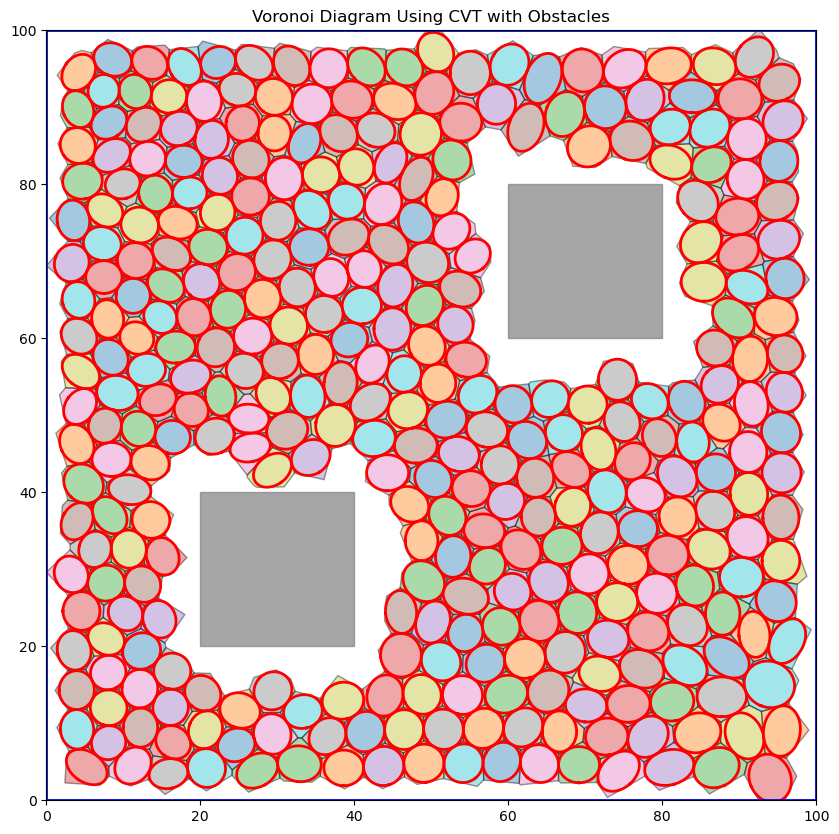

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, bounding_polygon, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect or go outside the bounding polygon.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                centroid = cell_polygon.centroid
                # Ensure the centroid is inside the bounding polygon
                if bounding_polygon.contains(centroid):
                    new_points.append(centroid.coords[0])
                else:
                    # If centroid is outside, keep the original point
                    # Alternatively, you could project it back onto the bounding polygon boundary
                    closest_point = bounding_polygon.exterior.interpolate(bounding_polygon.exterior.project(centroid))
                    new_points.append(closest_point.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)

def plot_voronoi(voronoi, bounding_polygon, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

            A_matrix, c = johns_ellipsoid_edge_constraints(cell_polygon)
            plot_ellipsoid(ax, A_matrix, c)
            

    # Plot Voronoi sites
    # plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot bounding polygon
    x, y = bounding_polygon.exterior.xy
    plt.plot(x, y, 'b-', lw=2)

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()

# Generate random initial points (Voronoi sites)
np.random.seed(42)
points = np.random.rand(500, 2) * 100  # 30 random points in a 100x100 space

# Define bounding polygon (a rectangular boundary)
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Perform Centroidal Voronoi Tessellation
iterations = 100
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles, constrained to the bounding polygon
    points = compute_centroids(voronoi, points, bounding_polygon, obstacles)

voronoi = compute_voronoi(points)
# Plot the resulting Voronoi diagram after CVT
plot_voronoi(voronoi, bounding_polygon, obstacles)

Mean (mu): [1.30659375e-15 9.19017063e-15]
Covariance Matrix (Sigma):
 [[0.81783007 0.7009972 ]
 [0.7009972  4.35619689]]


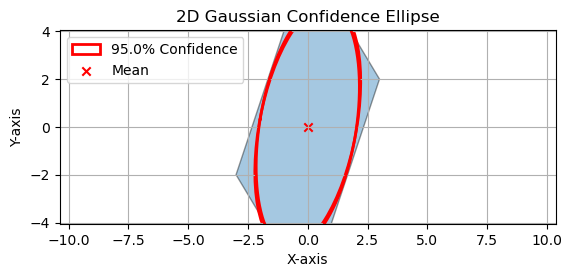

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def ellipsoid_to_gaussian(A, b, p):
    """
    Convert an ellipsoid equation x^T A x + b^T x + c = 0
    to a 2D Gaussian distribution with mean and covariance.
    
    Parameters:
    A (numpy.ndarray): 2x2 symmetric positive definite matrix defining the ellipsoid shape.
    b (numpy.ndarray): 2x1 vector defining the ellipsoid center shift.
    p (float): Confidence level (e.g., 0.95 for 95% confidence).
    
    Returns:
    mu (numpy.ndarray): Mean of the Gaussian.
    Sigma (numpy.ndarray): Covariance matrix of the Gaussian.
    """
    # Compute mean
    mu = b
    
    # Compute chi-squared value for the given confidence level
    chi2_val = chi2.ppf(p, df=2)
    
    # Compute covariance matrix
    Sigma = A.T@A /chi2_val
    
    return mu, Sigma

def plot_gaussian_ellipse(mu, Sigma, p, ax=None):
    """
    Plot the confidence ellipse of a 2D Gaussian distribution.
    
    Parameters:
    mu (numpy.ndarray): Mean of the Gaussian.
    Sigma (numpy.ndarray): Covariance matrix.
    p (float): Confidence level.
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib axis.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Compute eigenvalues and eigenvectors of covariance matrix
    eigvals, eigvecs = np.linalg.eigh(Sigma)
    
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # Compute the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    
    # Compute the width and height of the ellipse (scaled by chi2 value)
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(p, df=2))
    
    # Plot ellipse
    ellipse = Ellipse(mu, width, height, angle=angle, edgecolor='r',
                                             facecolor='none', linewidth=2, label=f'{p*100:.1f}% Confidence')
    ax.add_patch(ellipse)
    ax.scatter(*mu, color='red', marker='x', label='Mean')
    
    # Set axis limits
    ax.set_xlim(mu[0] - width, mu[0] + width)
    ax.set_ylim(mu[1] - height, mu[1] + height)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.legend()
    ax.set_title("2D Gaussian Confidence Ellipse")
    plt.grid()
    plt.show()

# Example usage
p = 0.95                        # 95% confidence level

polygon = Polygon([(-3, -2), (0, -7), (3, 2), (0, 7) ])
A, b = johns_ellipsoid_edge_constraints(polygon)

mu, Sigma = ellipsoid_to_gaussian(A, b, p)
print("Mean (mu):", mu)
print("Covariance Matrix (Sigma):\n", Sigma)

# Plot the confidence ellipse

x, y = polygon.exterior.xy
plt.fill(x, y, alpha=0.4, edgecolor='k')
ax = plt.gca()
ax.set_aspect("equal")
plot_ellipsoid(ax, A, b)
plot_gaussian_ellipse(mu, Sigma, p, ax)

